In [1]:

#read csv files for getting the data
import csv
import os
import sys
import pandas as pd
import numpy as np

#read the csv file
happpy_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\features_10_max_happinness.csv'
happy_df = pd.read_csv(happpy_csv)
happy_df['user'] = happy_df['0'].str.split('_').str[0]  
happy_df = happy_df.drop(columns=['0'])  
#remove rows with same user
happy_df.set_index('user', inplace=True)
happy_df = happy_df[~happy_df.index.duplicated(keep='first')]
#read the csv file
neutral_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\features_10_first_neutral.csv'
neutral_df = pd.read_csv(neutral_csv)
neutral_df['user'] = neutral_df['0'].str.split('_').str[0]
neutral_df = neutral_df.drop(columns=['0'])
neutral_df.set_index('user', inplace=True)
neutral_df = neutral_df[~neutral_df.index.duplicated(keep='first')]

In [2]:
sialorreha_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\saliva.csv'
map_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\map_id.csv'
saliva_df = pd.read_csv(sialorreha_csv)
saliva_df.set_index('ID', inplace=True)
map_df = pd.read_csv(map_csv)

saliva_df = saliva_df.join(map_df.set_index('Subjet ID'), on='ID')
#remove nan rows where 'ROMP_saliva_Q_done' is nan
saliva_df = saliva_df.dropna(subset=['ROMP_saliva_Q_done','Booth ID'])   
saliva_df = saliva_df[saliva_df['ROMP_saliva_Q_done'] == 'Y']
saliva_df.set_index('Booth ID', inplace=True)
saliva_df.drop(columns=['ROMP_saliva_Q_done','Date','Unnamed: 13'], inplace=True)
saliva_df.index = saliva_df.index.astype(int).astype(str)


In [3]:
def compute_features(df):
    sqrt_of_sums = np.sqrt(df.iloc[:, -2]**2 + df.iloc[:, -1]**2)

    # Divide all features by this value
    df = df.div(sqrt_of_sums, axis=0)

    # Drop the last two features
    df = df.iloc[:, :-2]
    return df

neutral_df = compute_features(neutral_df)
happy_df = compute_features(happy_df)

happy_df = happy_df.add_suffix('_happy')
neutral_df = neutral_df.add_suffix('_neutral')
#combine the two dataframes
combine_features_df = pd.concat([happy_df, neutral_df], axis=1, join='inner')

# Assuming 'participant_id' in combine_features_df corresponds to 'id' in saliva_df
merged_df = combine_features_df.join(saliva_df, how='inner', rsuffix='_saliva')


In [4]:

import pandas as pd
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the data
Y = scaler.fit_transform(merged_df.iloc[:,-10:])  # Features
X = scaler.fit_transform(merged_df.iloc[:,:-10])  # Questionnaire results

# Initialize CCA with the number of components to compute, let's assume the smaller number of columns in the two datasets
n_components = min(saliva_df.shape[1], combine_features_df.shape[1])
cca = CCA(n_components=n_components)

# Fit CCA
cca.fit(X, Y)

# Transform the data (this step computes the canonical variables)
X_c, Y_c = cca.transform(X, Y)


cca.coef_

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")


array([[-0.20380565, -0.31869234,  0.09051619,  0.26698914, -0.04499298,
        -0.68643059,  0.41309052,  0.08108813, -0.19091307, -0.15233596],
       [-0.19640471,  0.12578333, -0.15182589, -0.48588161, -0.41994491,
         0.18762994, -0.90414589, -0.54311066, -0.0565257 , -0.33475993],
       [-0.10525381, -0.03129526, -0.16425415,  0.00727451,  0.16674313,
         0.1409065 , -0.05863079,  0.01725253,  0.13628503, -0.00571221],
       [-0.01421322, -0.05913822, -0.43370919, -0.18640317, -0.19694272,
         0.05273732, -0.39262599, -0.01998441, -0.26593612, -0.23365874],
       [ 0.08378821,  0.11387352, -0.70071058,  0.28419589,  0.03562061,
        -0.49354962, -0.50697257,  0.38465623, -0.02636842, -0.12304208],
       [-0.25205014, -0.0285072 ,  0.38237327, -0.32047394, -0.14163425,
         0.34937186,  0.45678496, -0.41188482, -0.02273349, -0.03013176],
       [ 1.22741117,  0.34734562,  0.08898047,  0.46762256,  0.0526663 ,
        -0.12338822, -0.45540439, -0.25055038

In [82]:
import pandas as pd
from scipy.stats import pearsonr


# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Feature', 'Saliva_Column', 'Correlation', 'P-Value'])

# Iterate over each feature in combine_features_df
for feature in combine_features_df.columns:
    # Iterate over each column in saliva_df
    for column in saliva_df.columns:
        # Calculate the Pearson correlation coefficient and the p-value
        correlation, p_value = pearsonr(merged_df[feature], merged_df[column])
        
        # Append the results to the results_df
        results_df = results_df.append({'Feature': feature, 'Saliva_Column': column, 'Correlation': correlation, 'P-Value': p_value}, ignore_index=True)

# Optionally, you can filter the results to only keep significant correlations
significant_results_df = results_df[results_df['P-Value'] < 0.05]

print(significant_results_df)


       Feature                                      Saliva_Column  \
3      1_happy  Q4.  Does your (loss of) saliva impair your ea...   
13     2_happy  Q4.  Does your (loss of) saliva impair your ea...   
20     3_happy  Q1. Do you experience loss of saliva during th...   
80     9_happy  Q1. Do you experience loss of saliva during th...   
103  1_neutral  Q4.  Does your (loss of) saliva impair your ea...   
104  1_neutral  Q5. Does your (loss of) saliva impair your spe...   
113  2_neutral  Q4.  Does your (loss of) saliva impair your ea...   
114  2_neutral  Q5. Does your (loss of) saliva impair your spe...   
180  9_neutral  Q1. Do you experience loss of saliva during th...   
181  9_neutral  Q2. II. How often do you experience increased ...   
186  9_neutral  Q7. Does the loss of saliva limit you in conta...   

     Correlation   P-Value  
3      -0.393455  0.017593  
13     -0.350284  0.036224  
20      0.337215  0.044302  
80     -0.388587  0.019174  
103    -0.462859  0.004475

In [83]:
#save significant results to a csv file
significant_results_df.to_csv('significant_results_10feaure.csv', index=False)

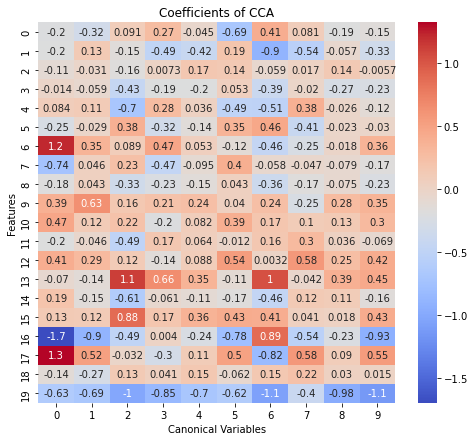

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming cca is your CCA object
plt.figure(figsize=(8, 7))
coefficients = cca.coef_

# Create a heatmap
sns.heatmap(coefficients, cmap='coolwarm', annot=True)

# Add labels and title
plt.xlabel('Canonical Variables')
plt.ylabel('Features')
plt.title('Coefficients of CCA')

# Show the plot
plt.show()


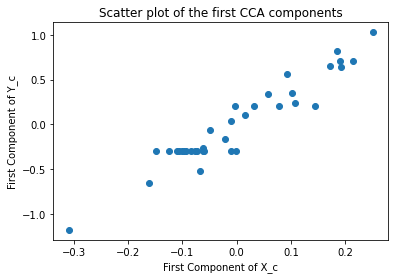

Canonical Correlations: [0.95484708 0.88629208 0.84512088 0.78603004 0.70200909 0.6397149
 0.59750275 0.47040991 0.36523659        nan]


c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [7]:
import matplotlib.pyplot as plt

plt.scatter(X_c[:, 0], Y_c[:, 0])
plt.xlabel('First Component of X_c')
plt.ylabel('First Component of Y_c')
plt.title('Scatter plot of the first CCA components')
plt.show()

# To examine the correlations
import numpy as np
correlations = np.corrcoef(X_c.T, Y_c.T)[:X_c.shape[1], X_c.shape[1]:]
print("Canonical Correlations:", np.diag(correlations))


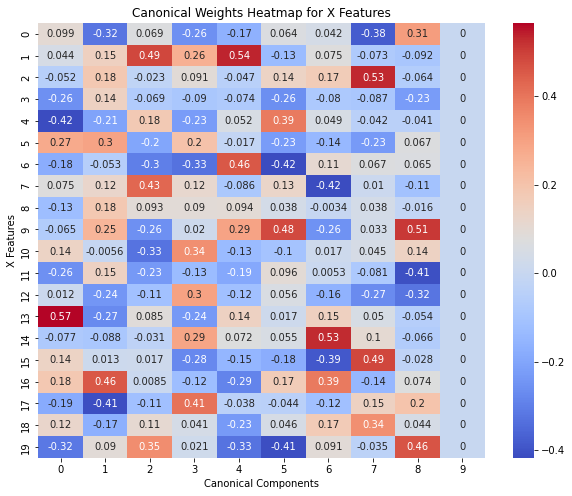

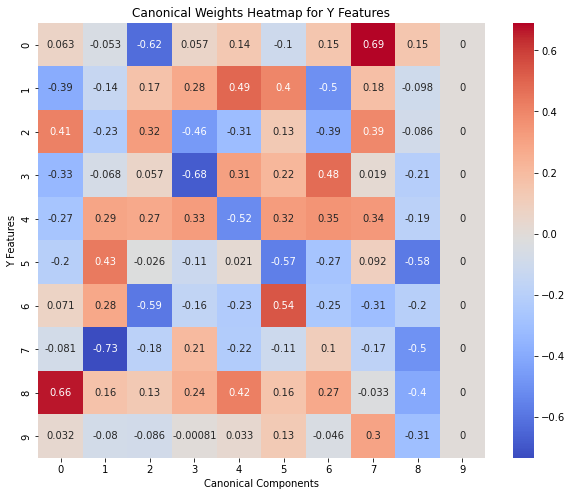

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

weights_X = cca.x_weights_  # Canonical weights for features in X
weights_Y = cca.y_weights_  # Canonical weights for features in Y

# Creating a heatmap for X weights
plt.figure(figsize=(10, 8))
sns.heatmap(weights_X, annot=True, cmap="coolwarm")
plt.title('Canonical Weights Heatmap for X Features')
plt.xlabel('Canonical Components')
plt.ylabel('X Features')
plt.show()

# Repeat similarly for Y weights
plt.figure(figsize=(10, 8))
sns.heatmap(weights_Y, annot=True, cmap="coolwarm")
plt.title('Canonical Weights Heatmap for Y Features')
plt.xlabel('Canonical Components')
plt.ylabel('Y Features')
plt.show()



In [10]:
from scipy.stats import pearsonr
import numpy as np

canonical_correlations = cca.score(X, Y)
print("Canonical Correlations:", canonical_correlations)

# Significance testing  using Pearson correlation
for i in range(len(X_c[0])):
    corr, p_value = pearsonr(X_c[:, i], Y_c[:, i])
    print(f"Correlation for pair {i+1}: {corr}, P-value: {p_value}")


Canonical Correlations: 0.3103503991857735
Correlation for pair 1: 0.954847077154844, P-value: 1.700162486885521e-19
Correlation for pair 2: 0.8862920790387445, P-value: 6.54617626316767e-13
Correlation for pair 3: 0.8451208767610937, P-value: 8.988411197188409e-11
Correlation for pair 4: 0.7860300361944301, P-value: 1.344290694770218e-08
Correlation for pair 5: 0.702009086035821, P-value: 1.8314487540006533e-06
Correlation for pair 6: 0.6397149023424691, P-value: 2.661075835712636e-05
Correlation for pair 7: 0.597502748302069, P-value: 0.0001192694977577636
Correlation for pair 8: 0.4704099135636536, P-value: 0.003789037241098191
Correlation for pair 9: 0.36523658649745133, P-value: 0.028496826282036546
Correlation for pair 10: nan, P-value: nan


c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train, X_test, Y_train, Y_test = train_test_split(X_c, Y, test_size=0.2, random_state=42)

# Instantiate and train the model
model = LinearRegression()
model.fit(X_train, Y_train)

# Predict on the testing set
Y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 1.944451735596039


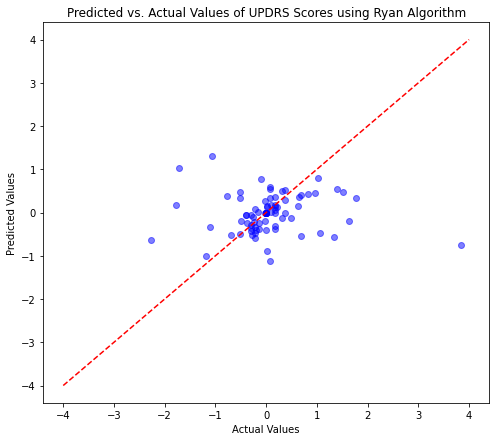

In [43]:
# Plot the predicted vs. actual values
plt.figure(figsize=(8, 7))
plt.scatter(Y_test, Y_pred, color='blue', alpha=0.5)
#draw a line from the origin to the top right corner
plt.plot([-4, 4], [-4, 4], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values of UPDRS Scores using Ryan Algorithm')
plt.show()